In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
from fastai.text import *

In [3]:
train = pd.read_csv("../input/train.csv")
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
train['comment_text'] = train['comment_text'].str.replace('([“”¨«»®´·º½¾¿¡§£₤‘’])', '')

In [5]:
test = pd.read_csv("../input/test.csv")

test_id = test['id']
test['comment_text'] = test['comment_text'].str.replace('([“”¨«»®´·º½¾¿¡§£₤‘’])', '')

In [6]:
data = (TextList.from_df(train, cols='comment_text')
                .split_by_rand_pct(0.2)
                .label_for_lm()  
                .databunch(bs=48))
data.show_batch()

idx,text
0,"background colour i 'm seemingly stuck with . xxmaj thanks . ( talk ) 21:51 , xxmaj january 11 , 2016 ( xxup utc ) xxbos xxmaj hey man , i 'm really not trying to edit war . xxmaj it 's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page . xxmaj he seems to care more about"
1,"the different types of magazines . xxmaj the purpose of including it is to show the other side of the controversy and according to my research within xxmaj wikipedia this is entirely acceptable . \n \n xxmaj agreement : xxmaj clearly some people do n't agree with m - w just as you and i do n't agree with xxup saami 's statement that people sometimes refer to """
2,"big red target on my back . xxmaj anyone can say anything they like about or to me , but i get blocked if i reply in kind . xxmaj to address xxmaj xxunk 's dishonesty below ( why am i not surprised to see that he considers this a good block ? ) , xxmaj xxunk only warned xxmaj xxunk ( and hardly "" "" sternly "" "" )"
3,"to see where things are headed and the onus is on them to correct . xxmaj if they do n't , you will have been patient and have given due warnings . xxmaj further , being more harsh than appropriate means you 've done something wrong , and you can not easily go backward from that . xxmaj however , if you are under harsh , you can always go"
4,"thousands of people daily . xxmaj along with a number of other scholar - related websites , i ca n't live without checking it by a daily basis . xxmaj it deserves a xxmaj wiki - article , where xxmaj jona xxmaj lendering is briefly described as the founder and maintainer of an outlet with roots as far back as xxunk . xxmaj yes , sounds like a plan of"


In [7]:
learn = language_model_learner(data,AWD_LSTM, drop_mult=0.3)

In [8]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


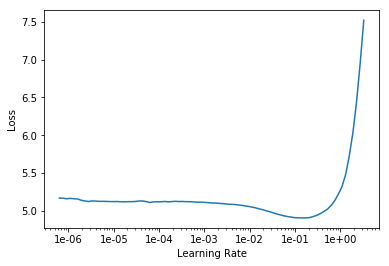

In [9]:
learn.recorder.plot()


In [10]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time


In [11]:
learn.save_encoder('fine_tuned_enc')

In [12]:
label_cols = ['toxic', 'severe_toxic' , 'obscene' , 'threat' , 'insult' , 'identity_hate']

In [13]:
test_datalist = TextList.from_df(test, cols='comment_text', vocab=data.vocab)

data_clas = (TextList.from_df(train, cols='comment_text', vocab=data.vocab)
             .split_by_rand_pct(0.2)
             .label_from_df(cols= label_cols , classes=label_cols)
             .add_test(test_datalist)
             .databunch(bs=32))

data_clas.show_batch()

text,target
xxbos xxmaj take that ! \n \n xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in,toxic;severe_toxic;obscene
"xxbos "" \n \n regarding a wiki writer \n \n xxmaj regarding the writer at http : / / rexcurry.net / wikipedialies.html and referenced at http : / / en.wikipedia.org / wiki / xxmaj talk : xxmaj hitler_salute please note the following : xxmaj mr. xxmaj barlow is a nutter with an obsession . xxmaj the history of the salute is now improved in the xxmaj roman salute",
"xxbos "" \n \n xxmaj regrettably , i have to agree about the xxmaj gameplay section . xxmaj it comes off more like an academic discourse on the incorporation of multiple characters and changes from previous franchise entries in video games , using xxmaj mother 3 as an example , than a proper encyclopedic entry . i wo n't quickfail just for this , but i do want it",
"xxbos "" \n \n xxmaj moving xxmaj ahead \n i just found that i am unblocked now . xxmaj this block reminded me of xxmaj hkelkar , xxmaj xxunk combination who used to get me blocked very often in very similar fashion . xxmaj the longest block so far . xxmaj perhaps , longer ones are in the way ! xxmaj people have already threatened it on my",
"xxbos xxmaj honestly the way wiki is treating this is a xxup joke \n \n a. i could have cited xxup news xxup sites but since when is a news site worthy of an academic cite ? \n \n b. if the person that wanted xxup peer xxup review felt like it , he would have sought it 20 years ago , xxup he xxup chose xxup not",toxic


In [14]:
learn_classifier = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn_classifier.load_encoder('fine_tuned_enc')
learn_classifier.freeze()


In [15]:
learn_classifier.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


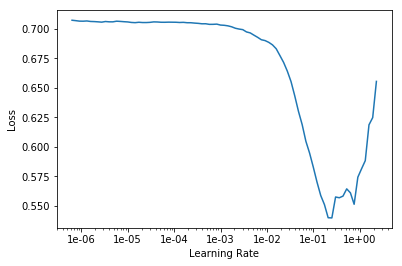

In [16]:
learn_classifier.recorder.plot()


In [17]:
learn_classifier.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))


epoch,train_loss,valid_loss,time
0,0.088130,0.067546,03:43


In [18]:
learn_classifier.freeze_to(-2)
learn_classifier.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.056726,0.055406,04:54


In [19]:
learn_classifier.freeze_to(-3)
learn_classifier.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.049260,0.045372,07:47


In [20]:
learn_classifier.show_results()


text,target,prediction
xxbos xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup,toxic,toxic;severe_toxic;obscene;threat;insult;identity_hate
xxbos ' ' ' xxmaj fuck xxmaj you ! xxmaj fuck xxmaj you ! xxmaj fuck xxmaj you ! xxmaj fuck xxmaj you ! xxmaj fuck xxmaj you ! xxmaj fuck xxmaj you ! xxmaj fuck xxmaj you ! xxmaj fuck xxmaj you ! xxmaj fuck xxmaj you ! xxmaj fuck xxmaj you ! xxmaj fuck xxmaj you ! xxmaj fuck xxmaj you ! xxmaj fuck xxmaj you ! xxmaj,toxic;severe_toxic;obscene,toxic;severe_toxic;obscene;insult
xxbos xxup hate xxup you xxup hate xxup you xxup hate xxup you xxup hate xxup you xxup hate xxup you xxup hate xxup you xxup hate xxup you xxup hate xxup you xxup hate xxup you xxup hate xxup you xxup hate xxup you xxup hate xxup you xxup hate xxup you xxup hate xxup you xxup hate xxup you xxup hate xxup you xxup hate xxup you xxup,toxic;insult,toxic;threat;insult;identity_hate
xxbos xxup ah xxup haahhahahah xxup yaaa xxup bitch y xxrep 4 a ! @ xxrep 6 ! xxup ah xxup haahhahahah xxup yaaa xxup bitch y xxrep 4 a ! @ xxrep 6 ! xxup ah xxup haahhahahah xxup yaaa xxup bitch y xxrep 4 a ! @ xxrep 6 ! xxup ah xxup haahhahahah xxup yaaa xxup bitch y xxrep 4 a ! @ xxrep 6 ! xxup,toxic;severe_toxic;obscene;insult,toxic;obscene;insult
xxbos xxup super xxup gay xxup super xxup gay xxup super xxup gay xxup super xxup gay xxup super xxup gay xxup super xxup gay xxup super xxup gay xxup super xxup gay xxup super xxup gay xxup super xxup gay xxup super xxup gay xxup super xxup gay xxup super xxup gay xxup super xxup gay xxup super xxup gay xxup super xxup gay xxup super xxup gay xxup,toxic,toxic;severe_toxic;obscene;threat;insult;identity_hate


In [21]:
preds, target = learn_classifier.get_preds(DatasetType.Test, ordered=True)
labels = preds.numpy()


In [22]:
labels

array([[9.925587e-01, 3.820060e-01, 9.303010e-01, 5.826220e-01, 8.698964e-01, 6.043553e-01],
       [4.183402e-03, 2.372991e-04, 1.640789e-03, 8.885576e-05, 1.255664e-03, 3.057827e-04],
       [5.171508e-03, 3.065799e-04, 2.432118e-03, 7.636040e-05, 1.590347e-03, 3.682395e-04],
       [3.487231e-04, 2.347832e-05, 1.339552e-04, 2.489422e-05, 1.187096e-04, 1.720202e-05],
       ...,
       [3.234277e-02, 1.208785e-03, 9.863478e-03, 3.248217e-03, 6.486647e-03, 2.811119e-03],
       [1.365523e-03, 4.294093e-05, 3.498457e-04, 3.094674e-05, 3.219346e-04, 8.907337e-05],
       [2.347157e-03, 5.334213e-05, 4.760315e-04, 6.219890e-05, 5.157578e-04, 4.414448e-04],
       [8.018025e-01, 1.138971e-02, 3.687390e-01, 1.547003e-03, 2.964555e-01, 7.235815e-03]], dtype=float32)

In [23]:
submission = pd.DataFrame({'id': test_id})
submission = pd.concat([submission, pd.DataFrame(preds.numpy(), columns = label_cols)], axis=1)

submission.to_csv('submission.csv', index=False)
submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.992559,0.382006,0.930301,0.582622,0.869896,0.604355
1,0000247867823ef7,0.004183,0.000237,0.001641,0.000089,0.001256,0.000306
2,00013b17ad220c46,0.005172,0.000307,0.002432,0.000076,0.001590,0.000368
3,00017563c3f7919a,0.000349,0.000023,0.000134,0.000025,0.000119,0.000017
4,00017695ad8997eb,0.012458,0.000499,0.001763,0.000310,0.002214,0.000336
